# 安装依赖库

In [1]:
# Install Transformers
! pip install transformers==3
# To get model summary
! pip install torchinfo
! pip install xlrd 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 754 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 44.2 MB/s 
     |████████████████████████████████| 880 kB 52.8 MB/s 
     |████████████████████████████████| 3.0 MB 47.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=522df71b4f2ea1d42c437b35f7ebb615d01551a34d9cce95eda38f5788c1fc7f
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt


In [3]:
# 导入数据
df = pd.read_excel("Chatbot_data.xlsx")
df.head()


,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


In [4]:
# 只留utterance和intent
df = df[['utterance','intent']]
df.head()

,utterance,intent
0,"I don't have an online account, what do I have...",create_account
1,can you tell me if i can regisger two accounts...,create_account
2,"I have no online account, open one, please",create_account
3,"could you ask an agent how to open an account,...",create_account
4,"i want an online account, create one",create_account


In [5]:
# 统计类别
df['intent'].value_counts()

payment_issue               4366
create_account              2122
contact_customer_service    2055
get_invoice                 1430
track_order                 1224
get_refund                  1150
contact_human_agent         1026
check_invoices              1013
recover_password             986
change_order                 926
delete_account               913
complaint                    746
review                       580
check_refund_policy          479
delivery_options             360
check_cancellation_fee       360
track_refund                 303
switch_account               273
check_payment_methods        270
newsletter_subscription      236
delivery_period              141
edit_account                 133
registration_problems        130
change_shipping_address      110
set_up_shipping_address       96
place_order                   70
cancel_order                  36
Name: intent, dtype: int64

In [6]:
# 为了将这些分类标签转换为数字编码，我们使用了LabelEncoder。
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['intent'] = le.fit_transform(df['intent'])


In [7]:
df['intent'].value_counts(normalize=True)

18    0.202749
10    0.098542
8     0.095430
15    0.066407
25    0.056840
16    0.053404
9     0.047646
4     0.047042
20    0.045788
1     0.043002
11    0.042398
7     0.034643
22    0.026934
6     0.022244
12    0.016718
3     0.016718
26    0.014071
24    0.012678
5     0.012538
17    0.010959
13    0.006548
14    0.006176
21    0.006037
2     0.005108
23    0.004458
19    0.003251
0     0.001672
Name: intent, dtype: float64

In [8]:
# 27个类别
len(df['intent'].value_counts(normalize=True))

27

In [9]:
# 变成训练集
train_text,train_labels = df['utterance'],df['intent']

# 我们尝试使用Bert base uncased、Roberta base和distilbert base Uncase模型进行训练。

In [10]:
from transformers import AutoModel, BertTokenizerFast

# 加载bert标记器
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# 加载bert预训练模型
bert = AutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
from transformers import RobertaTokenizer, RobertaModel
# Load the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Import Roberta pretrained model
bert = RobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [12]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [13]:
# 简单实用调包的东西
test = ['this is a model for training','data is oil']

encoded_input = tokenizer(test,padding=True,truncation=True,return_tensors='pt')
encoded_input

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 2944, 2005, 2731,  102],
        [ 101, 2951, 2003, 3514,  102,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0]])}

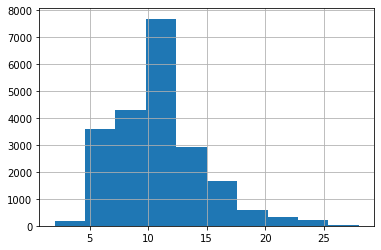

In [14]:
# 获取训练集中信息的长度
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins=10)

In [15]:
# 根据结果，设置最长句子长度为20
max_seq_len = 20

In [16]:
# 对训练集中的序列进行标记化和编码
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length = True,
    truncation=True,
    return_token_type_ids =False
)

In [17]:
# 将数据集转换为张量
train_seq = torch.tensor(tokens_train['input_ids']) 
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [18]:
# 为数据集创建一个数据加载器
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16 
# wrap dataset
train_data = TensorDataset(train_seq,train_mask,train_y)
# 随机采样
train_sampler = RandomSampler(train_data)


train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)


# 定义模型

In [29]:
class Bert_arch(nn.Module):
  def __init__(self,bert):
    super(Bert_arch,self).__init__()

    self.bert = bert 

    # droput 
    self.dropout = nn.Dropout(0.2)

    # relu
    self.relu = nn.ReLU()

    # dense 
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,256)
    # 最后输出类别--len(df['intent'].value_counts())
    self.fc3 = nn.Linear(256,27) 

    # softmax 
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self,sent_id,mask):
    # 初始层就是预训练的层 -bert
    cls_hs = self.bert(sent_id,attention_mask=mask)[0][:,0]
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    

    # output layer 
    x = self.fc3(x)
    x = self.softmax(x)

    return x 

In [30]:
# #冻结所有参数。这将防止在微调期间更新模型权重。
for param in bert.parameters():
  param.requires_grad=False 

model = Bert_arch(bert)
from torchinfo import summary 
summary(model)

Layer (type:depth-idx)                                  Param #
Bert_arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           6,939
├─LogSoftmax: 1-7                                       --
Total 

In [31]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr=1e-3)

In [32]:
train_labels

0        10
1        10
2        10
3        10
4        10
         ..
21529    23
21530    23
21531    23
21532    23
21533    23
Name: intent, Length: 21534, dtype: int64

In [33]:
# from sklearn.utils.class_weight import compute_class_weight

# # 计算权重
# class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels), y = train_labels)
# # class_wts = compute_class_weight(class_weight='balanced', y = np.unique(train_labels), classes = train_labels)

# class_wts

In [34]:
# # 在训练过程中使用权重来控制损失率
# weights = torch.tensor(class_wts,dtype=torch.float)


In [35]:
# loss function
# cross_entropy = nn.NLLLoss(weight=weights) 
cross_entropy = nn.NLLLoss() 

In [36]:
# 存储每次迭代的损失率
train_losses=[]
# number of training epochs
epochs = 10
# We can also use learning rate scheduler to achieve better results
# lr_sch = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [37]:
def train():
  model.train()
  total_loss = 0
  # 保存模型的预测
  total_preds = []

  for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 200 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    batch = [r for r in batch] 
    sent_id, mask, labels = batch
    # 得到当前的模型预测
    preds = model(sent_id, mask)
    
    # 在真实值和预测值之间计算损失
    loss = cross_entropy(preds, labels)
    
    # 累加损失
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients后向来计算梯度
    loss.backward()

  
    #将梯度 剪裁为1.0。这有助于防止梯度爆炸问题 
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # 更新参数
    optimizer.step()
    # 清零参数
    optimizer.zero_grad()
  
    #到目前为止，我们还没有使用学习速率调度程序
    #lr_sch.step（）
    #模型预测存储在GPU上。所以，把它推给CPU
    preds=preds.detach().cpu().numpy()
    # 存储模型的预测
    total_preds.append(preds)
  # 计算训练损失
  avg_loss = total_loss / len(train_dataloader)
      
  #预测的形式为（批次数量、批次大小、类别数量）。
  #以（样本数量、类别数量）的形式重新调整预测
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds


In [38]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 10
  Batch   200  of  1,346.
  Batch   400  of  1,346.
  Batch   600  of  1,346.
  Batch   800  of  1,346.
  Batch 1,000  of  1,346.
  Batch 1,200  of  1,346.

 Epoch 2 / 10
  Batch   200  of  1,346.
  Batch   400  of  1,346.
  Batch   600  of  1,346.
  Batch   800  of  1,346.
  Batch 1,000  of  1,346.
  Batch 1,200  of  1,346.

 Epoch 3 / 10
  Batch   200  of  1,346.
  Batch   400  of  1,346.
  Batch   600  of  1,346.
  Batch   800  of  1,346.
  Batch 1,000  of  1,346.
  Batch 1,200  of  1,346.

 Epoch 4 / 10
  Batch   200  of  1,346.
  Batch   400  of  1,346.
  Batch   600  of  1,346.
  Batch   800  of  1,346.
  Batch 1,000  of  1,346.
  Batch 1,200  of  1,346.

 Epoch 5 / 10
  Batch   200  of  1,346.
  Batch   400  of  1,346.
  Batch   600  of  1,346.
  Batch   800  of  1,346.
  Batch 1,000  of  1,346.
  Batch 1,200  of  1,346.

 Epoch 6 / 10
  Batch   200  of  1,346.
  Batch   400  of  1,346.
  Batch   600  of  1,346.
  Batch   800  of  1,346.
  Batch 1,000  of  1,346.


In [40]:
# 保存模型
torch.save(model.state_dict(),"model")

In [47]:
def get_prediction(str):
  str = re.sub(r'[^a-zA-Z ]+', '', str)
  test_text = [str]
  model.eval()
 
  tokens_test_data = tokenizer(
      test_text,
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
      )
  test_seq = torch.tensor(tokens_test_data['input_ids'])
  test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
  preds = None
  with torch.no_grad():
    preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  print('Intent Identified: ', le.inverse_transform(preds)[0])
  return le.inverse_transform(preds)[0]



In [48]:
def get_response(message): 
  intent = get_prediction(message)
  for i in df['intent']: 
    if i["intent"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [50]:
text = "how are you?"
intent = get_prediction(text)


Intent Identified:  contact_human_agent
